# FactoryML

## Hardware

In [23]:
!nvidia-smi

Fri Feb 21 00:23:37 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.86.16              Driver Version: 570.86.16      CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...    Off |   00000000:01:00.0  On |                  N/A |
| N/A   48C    P4             11W /  140W |    6272MiB /   8188MiB |     17%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Imports

In [24]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import pandas as pd
import numpy as np
import keras
print("Keras version: ", keras.__version__)
from keras import layers
from matplotlib import pyplot as plt

Keras version:  3.8.0


## Loading data

In [25]:
df = pd.read_csv(
    './data/dataset.csv', 
    index_col='DateTime', 
    parse_dates=True)
df.drop(df.columns.difference([
        'DateTime', 
        '004_1010-101-201-PECH-0001-P11.MV.MV120'
    ]), axis=1, inplace=True)

df.head()

,004_1010-101-201-PECH-0001-P11.MV.MV120
DateTime,
2025-01-13 00:00:00+00:00,172.508301
2025-01-13 00:01:00+00:00,172.508301
2025-01-13 00:02:00+00:00,172.508301
2025-01-13 00:03:00+00:00,172.508301
2025-01-13 00:04:00+00:00,172.508301


# Preprocessing

In [34]:
# replace missing values with the mean of the neighbours 

df['004_1010-101-201-PECH-0001-P11.MV.MV120'] = df['004_1010-101-201-PECH-0001-P11.MV.MV120'].interpolate()


## Visualize

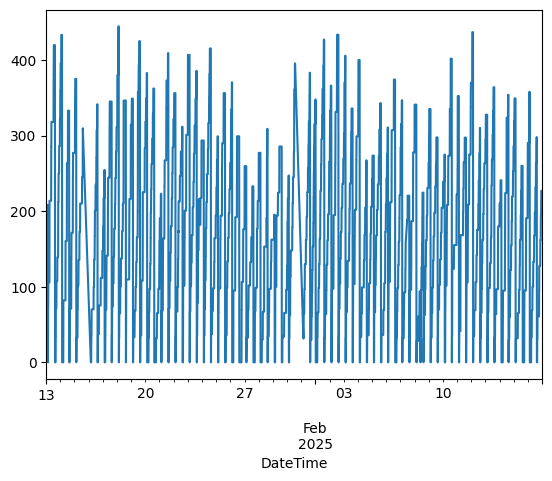

In [36]:
fig, ax = plt.subplots()
df.plot(legend=False, ax=ax)
plt.show()


# Learning

In [37]:
training_mean = df.mean()
training_std = df.std()
df_training_value = (df - training_mean) / training_std
print("Number of training samples:", len(df_training_value))

Number of training samples: 50400


In [38]:
TIME_STEPS = 200

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)


Training input shape:  (50201, 200, 1)


In [39]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32,
            kernel_size=7,
            padding="same",
            strides=2,
            activation="relu",
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16,
            kernel_size=7,
            padding="same",
            strides=2,
            activation="relu",
        ),
        layers.Conv1DTranspose(
            filters=16,
            kernel_size=7,
            padding="same",
            strides=2,
            activation="relu",
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32,
            kernel_size=7,
            padding="same",
            strides=2,
            activation="relu",
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 100, 32)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 100, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 50, 16)         │         3,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_9              │ (None, 100, 16)        │         1,808 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 100, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_10             │ (None, 200, 32)        │         3,616 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_11             │ (None, 200, 1)         │           225 │
│ (Conv1DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,505 (37.13 KB)

 Trainable params: 9,505 (37.13 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=256,
    validation_split=0.1,
)


Epoch 1/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.2905 - val_loss: 0.0143
Epoch 2/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0183 - val_loss: 0.0134
Epoch 3/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0111 - val_loss: 0.0176
Epoch 4/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0083 - val_loss: 0.0249
Epoch 5/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0067 - val_loss: 0.0285
Epoch 6/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0057 - val_loss: 0.0261
Epoch 7/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0049 - val_loss: 0.0269
Epoch 8/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0044 - val_loss: 0.0232
Epoch 9/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0040 - val_loss: 0.0224
Epoch 10/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0037 - val_loss: 0.0203
Epoch 11/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0034 - val_loss: 0.0193
Epoch 12/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

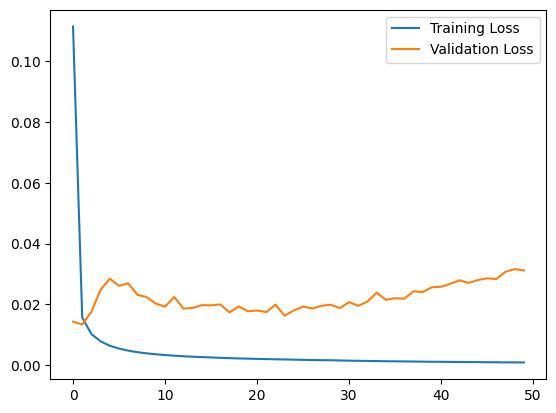

In [41]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

1569/1569 ━━━━━━━━━━━━━━━━━━━━ 1s 620us/step


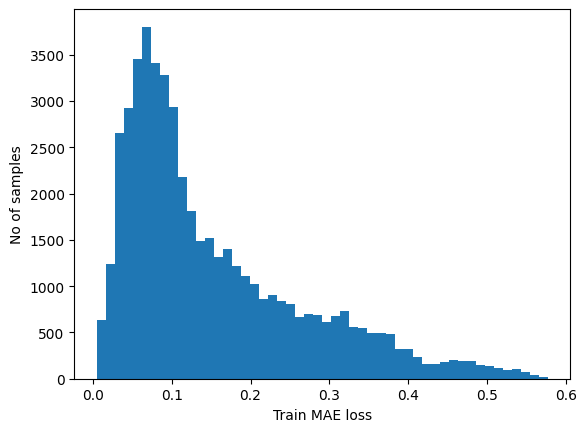

Reconstruction error threshold:  0.5771272458600594


In [42]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

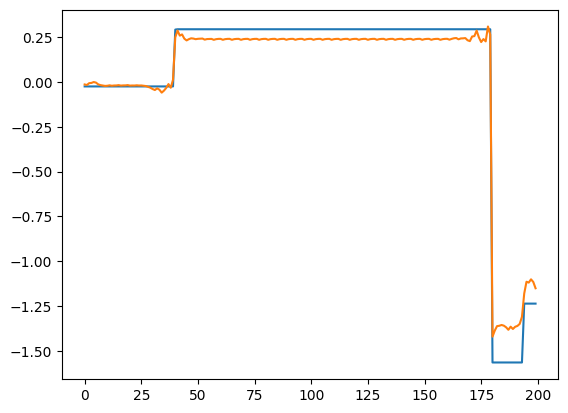

In [43]:
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()